# Oversmoothing Analysis of Node Classification

### Setup

In [35]:
import os

import torch
import torch.nn.functional as F
import torch.nn as nn

from torch_geometric.utils import add_remaining_self_loops, degree
from torch_scatter import scatter
from torch_geometric.nn import GINConv, global_add_pool, global_mean_pool, GCNConv, GATConv, SimpleConv
from torch_geometric.datasets import HeterophilousGraphDataset
from torch_geometric.loader import DataLoader
from torch.nn import Sequential, Linear, BatchNorm1d, ReLU

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### 1) Find and Download Datasets for Node Classification dataset link

***Roman Empire***

* Based on the Roman Empire article from Wikipedia
* Each node corresponds to a word in the text
* Each word is connected to another if the word follows or there is a dependency within the sentence
* The class of the node is its syntactic role found using spaCy
* Node features are fastText word embeddings

In [5]:
rome = HeterophilousGraphDataset(root='data/', name='Roman-empire')

***Amazon Ratings***

In [6]:
amazon = HeterophilousGraphDataset(root='data/', name='Amazon-ratings')

***Minesweeper***

* 100x100 grid
* Each cell is connected to its eight neighbors
* Mines vs not mines
  * Binary classes
  * 20% are mines
* Node features are one-hot-encoded numbers of neighboring mines

In [7]:
minesweeper = HeterophilousGraphDataset(root='data/', name='Minesweeper')

***Tolokers***

In [8]:
tolo = HeterophilousGraphDataset(root='data/', name='Tolokers')

***Questions***

In [9]:
questions = HeterophilousGraphDataset(root='data/', name='Questions')

### 2) Code GNN-based models and obtain node classification performance
* Define GCN
* Get baseline results

In [19]:
class GCN(torch.nn.Module):
    def __init__(
            self, 
            in_channels,
            conv_channels: list,
            mlp_channels: list,
            out_channels,
            heads=4,
        ):
        super(GCN, self).__init__()

        self.n_conv_layers = len(conv_channels)
        self.n_mlp_layers = len(mlp_channels)

        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(p=0.2)

        self.convs = nn.ModuleList([
            GATConv(in_channels, conv_channels[0], heads, concat=True),
            *[GATConv(conv_channels[i - 1] * heads, conv_channels[i], heads) for i in range(1, self.n_conv_layers)],
            GATConv(conv_channels[-1] * heads, mlp_channels[0], heads),
        ])

        self.batch_norms = nn.ModuleList([
            nn.BatchNorm1d(conv_channels[0] * heads),
            *[nn.BatchNorm1d(conv_channels[i] * heads) for i in range(1, self.n_conv_layers)],
            nn.BatchNorm1d(mlp_channels[0] * heads),
        ])

        self.projections = nn.ModuleList([
            nn.Linear(in_channels + conv_channels[0] * heads, conv_channels[0] * heads),
            *[nn.Linear(conv_channels[i - 1] * heads + conv_channels[i] * heads, conv_channels[i] * heads) for i in range(1, self.n_conv_layers)],
            nn.Linear(conv_channels[-1] * heads + mlp_channels[0] * heads, mlp_channels[0] * heads),
        ])

        self.fc1 = nn.Linear(mlp_channels[0] * heads, mlp_channels[1])
        self.fc2 = nn.Linear(mlp_channels[1], out_channels)
        
    def forward(self, x, edge_index, return_emb=False):
        embeddings = []
        
        skip = x

        for i, conv in enumerate(self.convs):
            # Conv + batch norm
            x = conv(x, edge_index)
            if return_emb:
                embeddings.append(x)
            x = self.batch_norms[i](x)

            # Skip connections + linear projection
            x = torch.cat([x, skip], dim=1)
            x = self.projections[i](x)
            skip = x

            # Activation + dropout
            x = self.gelu(x)
            x = self.dropout(x)

        # MLP
        x = self.gelu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        output = F.log_softmax(x, dim=1)

        if return_emb:
            return output, embeddings

        return output

In [65]:
conv_channels_list = [256, 256]
mlp_channels_list = [64, 32]
num_heads = 8

dataset = minesweeper.to(device)
weights_path = f"models/gcn_{dataset.name}.pth"

class_weights = None # torch.tensor([1/0.8, 1/0.2]).to(device)

model = GCN(
    in_channels=dataset.num_node_features,
    conv_channels=conv_channels_list,
    mlp_channels=mlp_channels_list,
    out_channels=dataset.num_classes,
    heads=num_heads,
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-5, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=50)
criterion = nn.NLLLoss(weight=class_weights)  # Use if returning log_softmax

split_index = 0
train_mask = dataset.train_mask[:, split_index]
val_mask = dataset.val_mask[:, split_index]
test_mask = dataset.test_mask[:, split_index]

# Training loop
def train():
    model.train()
    optimizer.zero_grad()
    out = model(dataset.x, dataset.edge_index)
    loss = criterion(out[train_mask], dataset.y[train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Evaluation loop
def evaluate():
    model.eval()
    with torch.no_grad():
        logits = model(dataset.x, dataset.edge_index)
        pred = logits.argmax(dim=1)
        accs = []
        for mask in [train_mask, val_mask, test_mask]:
            acc = (pred[mask] == dataset.y[mask]).sum().item() / mask.sum().item()
            accs.append(acc)
    return accs

# Training process
num_epochs = 500
for epoch in range(num_epochs):
    loss = train()
    train_acc, val_acc, test_acc = evaluate()
    if epoch % 50 == 0 or epoch == (num_epochs - 1):
        print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, '
              f'Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch 000, Loss: 0.6317, Train Acc: 0.8000, Val Acc: 0.8000, Test Acc: 0.8000
Epoch 050, Loss: 0.4228, Train Acc: 0.8000, Val Acc: 0.8000, Test Acc: 0.8000
Epoch 100, Loss: 0.3555, Train Acc: 0.8362, Val Acc: 0.8304, Test Acc: 0.8328
Epoch 150, Loss: 0.3030, Train Acc: 0.8622, Val Acc: 0.8348, Test Acc: 0.8536
Epoch 200, Loss: 0.2780, Train Acc: 0.8744, Val Acc: 0.8320, Test Acc: 0.8524
Epoch 250, Loss: 0.2645, Train Acc: 0.8852, Val Acc: 0.8276, Test Acc: 0.8460
Epoch 300, Loss: 0.2450, Train Acc: 0.8952, Val Acc: 0.8268, Test Acc: 0.8420
Epoch 350, Loss: 0.2268, Train Acc: 0.9118, Val Acc: 0.8208, Test Acc: 0.8388
Epoch 400, Loss: 0.2071, Train Acc: 0.9186, Val Acc: 0.8140, Test Acc: 0.8320
Epoch 450, Loss: 0.1857, Train Acc: 0.9338, Val Acc: 0.8144, Test Acc: 0.8352
Epoch 499, Loss: 0.1701, Train Acc: 0.9458, Val Acc: 0.8096, Test Acc: 0.8316


In [20]:
model = GCN(
    in_channels=dataset.num_node_features,
    conv_channels=conv_channels_list,
    mlp_channels=mlp_channels_list,
    out_channels=dataset.num_classes,
    heads=num_heads,
).to(device)

sum(p.numel() for p in model.parameters())

21335138

In [28]:
# Save model
torch.save(model.state_dict(), weights_path)

### 3) Change the Message-passing layer and obtain performance for each layer
* Test different message-passing layers
* Test different number of layers

### 4) Analyze the relationship between the number of message-passing layers and the node classification performance
* Visualize oversmoothing

In [29]:
# Load model from file
model = GCN(
    in_channels=dataset.num_node_features,
    conv_channels=conv_channels_list,
    mlp_channels=mlp_channels_list,
    out_channels=dataset.num_classes,
    heads=num_heads,
).to(device)

model.load_state_dict(torch.load(weights_path, weights_only=True))

<All keys matched successfully>

In [66]:
loader = DataLoader(dataset, batch_size=1) #shuffle=True)

batch = next(iter(loader))
with torch.no_grad():
    logits, embeddings = model(batch.x, batch.edge_index, return_emb=True)

predictions = logits.argmax(dim=1)
predictions

tensor([0, 1, 0,  ..., 0, 0, 0], device='cuda:0')

In [67]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200, max_iter=1000)

emb_2d = []

for i, emb in enumerate(embeddings):
    emb_2d.append(tsne.fit_transform(emb.cpu().numpy()))

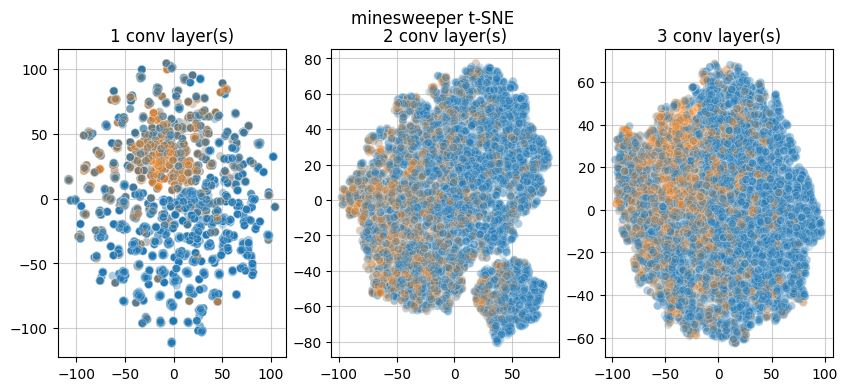

In [ ]:
n_emb = len(emb_2d)

fig, axes = plt.subplots(1, n_emb, figsize=(10, 4))

for i, ax in enumerate(axes):
    data = emb_2d[i]

    sns.scatterplot(x=data[:, 0], y=data[:, 1], hue=dataset.y.cpu(), ax=ax, alpha=0.2)
                    
    ax.set_title(f"{i} conv layer(s)")
    ax.get_legend().remove()
    ax.set_axisbelow(True)
    ax.grid(alpha=0.6)

plt.suptitle(f"{dataset.name} t-SNE")

plt.show()